# A Gallery of Projective Geometric Algebra
Ted Corcovilos
2021-03-09

## Preliminaries
This section is setup material that does not display in the final presentation.

To display correctly, this notebook requires classic Jupyter notebook (not Jupyterlab) with the following notebook extensions:
* RISE
* Python Markdown
* Hide input
* Split cells notebook

In [1]:
from clifford import *

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import warnings

In [2]:
# define 2D PGA
layout, blades = Cl(2,0,1, firstIdx=0)
locals().update(blades)

In [3]:
# helper functions
point = lambda x, y, w=1.0 : (x*e1+y*e2+w*e0).dual()
line = lambda a, b, c: a*e1+b*e2+c*e0

In [4]:
def rand_line(num=1,length=1.0):
    '''
    generates 'num' random (normalized) lines with maximum moment of 'length'
    '''
    # a line looks like xe1 + ye2 + ce0 and is normalized if x**2 + y**2 = 1
    # So, we'll use a polar form for x and y
    angle = 2.0*np.pi* np.random.random(num) # random angle between 0 and 2pi radians
    x = np.cos(angle)
    y = np.sin(angle)
    c = np.random.random(num)*length
    if num == 1:
        line = MultiVector(layout,[0,c[0],x[0],y[0],0,0,0,0])
    else:
        line = [MultiVector(layout,[0,c[i],x[i],y[i],0,0,0,0]) for i in range(num)]
    return(line)
    

In [5]:
def rand_point(num=1,length=1.0):
    '''
    generates 'num' random (normalized) lines with maximum moment of 'length'.
    length=0 generates ideal points
    '''
    # a normalized point looks like -xe02 + ye01 + e12 
    # So, we'll use a polar form for x and y
    angle = 2.0*np.pi* np.random.random(num) # random angle between 0 and 2pi radians
    if length == 0:
        x = np.cos(angle)
        y = np.sin(angle)
        w = 0.0
    else:    
        c = np.random.random(num)*length
        x = np.cos(angle)*c
        y = np.sin(angle)*c
        w = 1.0
        
    if num == 1:
        point = MultiVector(layout,[0,0,0,0,y[0],-x[0],w,0])
    else:
        point = [MultiVector(layout,[0,0,0,0,y[i],-x[i],w,0]) for i in range(num)]
    return(point)
    

## The plotting function `add_to_axes`
This draws a PGA object to an existing `matplotlib` axes object. The function classifies the object by geometric type then draws an appropriate representation onto the figure axes.

In [6]:
def add_to_axes(x,label=None,color='black',axis=None,eps = 1e-6,**kwargs):
    # plot 2D PGA points and lines on a pyplot axis
    # label = point label for drawing
    # axis = axis object to write to, defaults to last used
    # eps = threshold for rounding to zero during type check
    
    # FIXME things are screwy if the object is outside the bounds of the figure
    
    x.clean(eps=eps)
    if axis==None:
        # get current axis
        axis = plt.gca()
    
    # get boundaries (for drawing lines)
    xmin, xmax = axis.get_xbound()
    ymin, ymax = axis.get_ybound()
    # bounding box as PGA lines:
    # corners
    corners = [point(xmin,ymin),point(xmax,ymin),point(xmax,ymax),point(xmin,ymax)]
    # edges 
    edges = [line(0,-1,ymin),line(-1,0,xmax),line(0,1,-ymax),line(1,0,-xmin)]
    
    # check object type:
    # real point, ideal point
    # line, idea line (how to draw?)
    grades = x.grades()
    if grades == set({1}): # it's a line!
        # check for ideal line
        if (x(e1) == 0) and (x(e2) == 0): # ideal line
            ellipse = Ellipse([0.5*(xmin+xmax),0.5*(ymin+ymax)],
                             width = xmax-xmin, height = ymax-ymin,
                             facecolor='none',edgecolor=color,ls='--')
            axis.add_artist(ellipse)
            axis.annotate(label,xycoords='figure fraction',
                         xy=(0.8,0.8), color=color, **kwargs)
        else: # real line
            # find which sides the line crosses
            # H/T enki
            crossing = [np.sign((corners[j]^x)[7]*(corners[(j+1)%4]^x)[7])==-1 for j in range(4)]
            edges_crossed = [edges[j] for j in range(4) if crossing[j]]
            if len(edges_crossed)==0:
                # the line is outside the box
                # FIXME edge cases: line intersects one of the corner points
                warnings.warn("Line outside window")
                return
            crosspoints = [x^j for j in edges_crossed]
            
            cross_x = [-j[5]/j[6] for j in crosspoints]
            cross_y = [j[4]/j[6] for j in crosspoints]
            axis.plot(cross_x,cross_y,color=color)
            
            labelx = 0.9*(-cross_x[0]+cross_x[1])+cross_x[0]
            labely = 0.9*(-cross_y[0]+cross_y[1])+cross_y[0]
            axis.annotate(
                label, xycoords='data',
                xy=(labelx,labely), textcoords='offset pixels',
                xytext=(5,5),
                color=color,
                **kwargs)
            

    elif grades == set({2}): # it's a point!
        # check if real point or ideal point
        if x(e12) == 0: # ideal point
            # ideal point will be drawn as an arrow at center of graph
            # TODO arrow at boundary?
            axis.annotate(
                label, xy=(0.5,0.5), xycoords='figure fraction',
                xytext=(-x[5]*0.1+0.5,x[4]*0.1+0.5), textcoords='figure fraction',
                arrowprops=dict(arrowstyle="<-",ec=color,fc=color),
                color=color,
                **kwargs)
        else: # real point
            axis.scatter(-x[5]/x[6],x[4]/x[6],color=color,**kwargs)
            axis.annotate(
                label, xycoords='data',
                xy=(-x[5]/x[6],x[4]/x[6]), textcoords='offset pixels',
                xytext=(5,5),
                color=color,
                **kwargs)
           
    else:
        # uh oh.  I don't know how to handle this
        # throw a warning and exit
        warnings.warn("Object is not a point or line.  Ignoring.")

## Generate some example objects

In [7]:
# generate 3 points
A, B, C = rand_point(3,5.0)
[A,B,C]

[-(0.03792^e01) - (0.12268^e02) + (1.0^e12),
 (3.34561^e01) + (1.42763^e02) + (1.0^e12),
 -(2.16544^e01) + (3.30355^e02) + (1.0^e12)]

In [8]:
# calculate (unnormalized) lines as joins of points
a = B&C
b = C&A
c = A&B
[a,b,c]

[(14.14383^e0) + (5.51105^e1) - (1.87592^e2),
 (0.39092^e0) - (2.12752^e1) + (3.42623^e2),
 (0.35631^e0) - (3.38353^e1) - (1.55031^e2)]

In [9]:
# define an ideal point and THE ideal line
idealpoint = rand_point(1,0)
idealline = 1*e0

## Make a plot

<ipython-input-6-6c4717922bdf>:44: UserWarning: Line outside window
  warnings.warn("Line outside window")


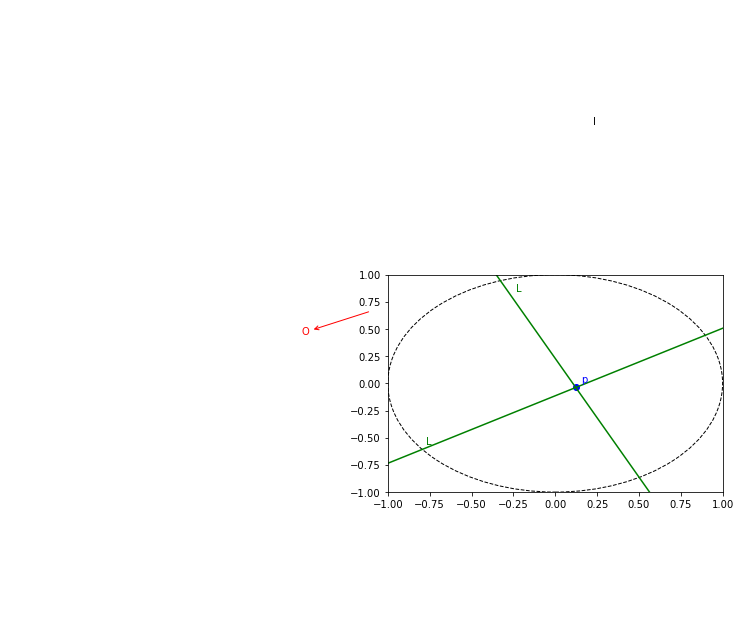

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# to avoid weird results, set the axis limits before plotting
ax.set_ylim(-1,1)
ax.set_xlim(-1,1)
add_to_axes(idealpoint,label="O",color='red',axis=ax)
for XX in [A,B,C]:
    add_to_axes(XX,label="p",color='blue',axis=ax)
for XX in [a,b,c]:
    add_to_axes(XX,label="L",color='green',axis=ax)
add_to_axes(idealline,label="I",color='black',axis=ax)
fig.show()

# Lines
In 2-dimensional Projective Geometric Algebra (PGA), the most basic object is a _line_, which is represented by a _vector_.  If we take an algebraic equation for a line in the _xy_-plane
$$ ax+by+c = 0, $$
then the vector representing this line is defined to be
$$ \ell = a e_1 + b e_2 + c e_0. $$

The _e_'s are our notation for the basis vectors.  $e_1$ and $e_2$ represent the _x_-direction and _y_-direction, respectively. $e_0$ is an extra "ideal" direction, that roughly speaking, counts distance from the origin.

## Example lines
$$ \ell = a e_1 + b e_2 + c e_0. $$
* Lines with $\color{red}{a=0}$ are the horizontal lines $y=-c/b$.
* Lines with $\color{blue}{b=0}$ are the vertical lines $x=-c/a$.
* Lines with $\color{green}{c=0}$ pass through the origin.

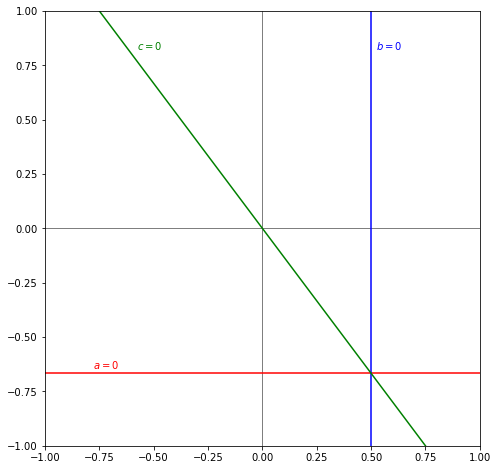

In [11]:
l1 = line(0,1.5,1.0)
l2 = line(-2,0,1)
p = l1^l2
l3 = e12 & p
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
# to avoid weird results, set the axis limits before plotting
ax.set_ylim(-1,1)
ax.set_xlim(-1,1)
ax.plot([1,-1],[0,0],color='black',lw=0.5)
ax.plot([0,0],[1,-1],color='black',lw=0.5)
ax.set_aspect(1)
add_to_axes(l1,label="$a=0$",color='red')
add_to_axes(l2,label="$b=0$",color='blue')
add_to_axes(-l3,label="$c=0$",color='green')
fig.show()

In [12]:
pretty(2)
l1 = (point(3,0)&point(0,4))
l2 = (point(0,0)&point(4,3)).normal()
l3 = (point(-3,0)&point(0,-4)).normal()

## Example lines
$$ \ell = a e_1 + b e_2 + c e_0. $$
* Line $\color{red}{\ell_1}$ is {{l1}}.
* Line $\hat{\ell}_1$ is {{l1.normal()}} (same line, but normalized).
* Line $\color{blue}{\ell_2}$ is {{l2}}.
* Line $\color{green}{\ell_3}$ is {{l3}}.

Note that $\color{red}{\ell_1} \parallel \color{green}{\ell_3}$, and both are $\perp \color{blue}{\ell_2}$.
We'll see how to verify this later.

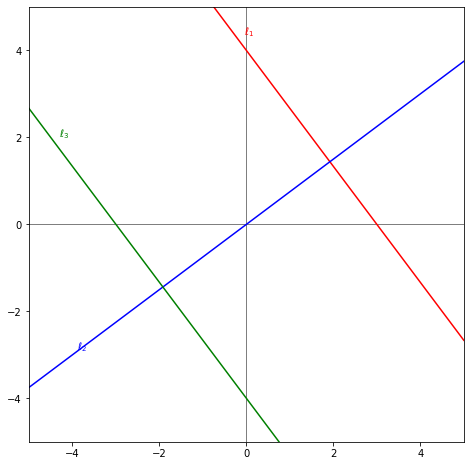

In [13]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
# to avoid weird results, set the axis limits before plotting
ax.set_ylim(-5,5)
ax.set_xlim(-5,5)
ax.plot([5,-5],[0,0],color='black',lw=0.5)
ax.plot([0,0],[5,-5],color='black',lw=0.5)
ax.set_aspect(1)
add_to_axes(l1,label="$\ell_1$",color='red')
add_to_axes(l2,label="$\ell_2$",color='blue')
add_to_axes(l3,label="$\ell_3$",color='green')
fig.show()

## Congruency
Note that multiplying a vector by a nonzero scalar constant does not change its geometric representation -- it gives the same line.  We say that two such vectors are _congruent_.
$$
\ell \equiv k\ell,
$$
where _k_ is a nonzero scalar.

## Normalization
If multiplying a vector by a scalar does not change its meaning, is there a prefered version of the vector representing a particular line?  For many things, this does not matter, but when we start measuring lengths and angles, the _normalization_ of the vectors will be important.  We define the _norm_ of line
$ \ell = a e_1 + b e_2 + c e_0 $
to be
$$ \lVert \ell \rVert = \sqrt{a^2+b^2}. $$

If $\lVert \ell \rVert = 0$, then the line is an _ideal line_ which, roughly, represents the boundary infinitely far away encircling the plane.

We _normalize_ a line by dividing it by its norm:
$$ \hat{\ell} = \frac{\ell}{\lVert \ell \rVert}, $$
where the ^ signifizes normalization.

## Normalized lines
If line $\ell= a e_1 + b e_2 + c e_0$ is already normalized, then $|c|$ is the distance from the origin to the line.
Also, $\theta = -\arcsin a =\arccos b$,  is the angle that the line makes with the _x_-axis.

The line shown here is
$\hat{\ell} = \tfrac35 e_1 -\tfrac45 e_2 -\tfrac25 e_0$.

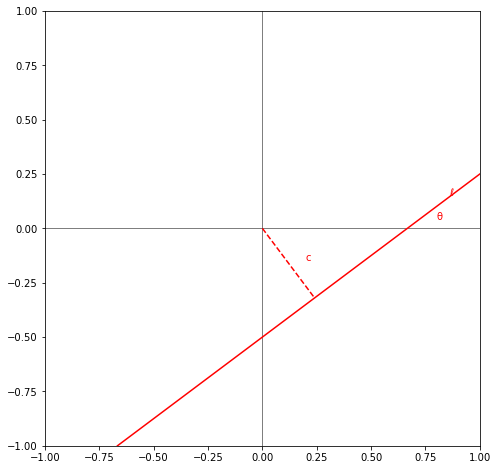

In [14]:
l1 = line(0.6,-0.8,-0.4)
perp = (l1|e12)*l1
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
# to avoid weird results, set the axis limits before plotting
ax.set_ylim(-1,1)
ax.set_xlim(-1,1)
ax.plot([1,-1],[0,0],color='black',lw=0.5)
ax.plot([0,0],[1,-1],color='black',lw=0.5)
ax.set_aspect(1)
add_to_axes(l1,label="$\ell$",color='red')
ax.plot([0,-perp[5]/perp[6]],[0,perp[4]/perp[6]]
        ,color='red',ls='--'
       )
ax.annotate(xy=(0.2,-0.15),
           text='c',color='red')
ax.annotate(xy=(0.8,0.04),text="θ",
           color='red')
fig.show()

(Note, I've neglected orientation here.  That is a whole other topic.)

# The exterior product $\wedge$
We'll see several types of products in GA.  Our first is the _exterior_ or "wedge" product, represented by $\wedge$.  The wedge product of two vectors obeys a simple rule:
$$ a \wedge b = - b \wedge a.$$
It does not simplify except in the special case the two vectors are congruent.
Then their exterior product equals zero.

## Bivectors
The product of two non-congruent vectors will be a new type of object, called a _bivector_.

If we take wedge products of the three basis vectors $e_1, e_2, e_0$, the unique nonzero combinations are
$$
e_2 \wedge e_0,\quad e_0 \wedge e_1,\quad e_1 \wedge e_2.
$$
These are the basis bivector for our system.
(The order here is chosen for convenience later.)

To save writing, we'll often abbreviate the wedge product of basis vectors by combining their subscripts.  For example,
$$ e_2 \wedge e_0 \rightarrow e_{20} .$$

In [15]:
#scratch
(3*e1+4*e2)^(1*e2+3*e0)

-(9^e01) - (12^e02) + (3^e12)

### Example calculations
$$ 2 e_2 \wedge 3 e_1 = 6 e_2\wedge e_1 = -6 e_1 \wedge e_2 = -6 e_{12} $$

$$ \begin{aligned}
(3 e_1 + 4 e_2) \wedge (1e_2 + 3e_0) & = 3 e_1\wedge e_2 + 9 e_1\wedge e_0 + 4 \underbrace{e_2 \wedge e_2}_0 + 12 e_2\wedge e_0 \\
&= 3 e_1\wedge e_2 - 9 e_0\wedge e_1 + 12 e_2\wedge e_0 \\
&= 3 e_{12} -9 e_{01} + 12e_{20}
\end{aligned}
$$

## Trivector
The only nonzero basis trivector in 2D PGA is
$$ e_0\wedge e_1 \wedge e_2 \rightarrow e_{012}, $$
which is also called the _pseudoscalar_ and is sometimes represented by the symbol $I$.

The wedge product of 4 or more vectors always equals zero in 2D PGA.

## Points
What do bivectors in 2D PGA represent?  Points!

The bivector
$$ P =  x e_{20} + y e_{01} + 1 e_{12}$$
represents a point at coordinates (_x_, _y_).

The point shown here is
$$ P = \frac12 e_{20} + \frac34 e_{01} + 1 e_{12}.$$

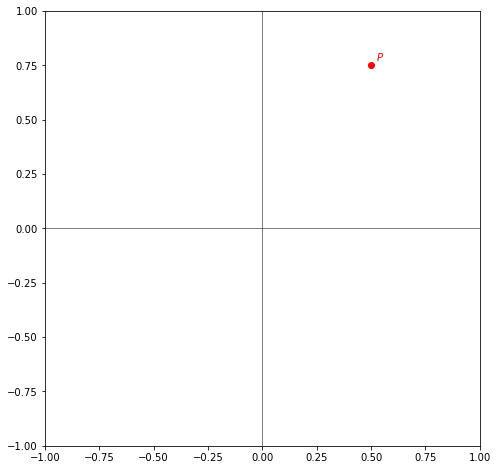

In [16]:
p = point(0.5,0.75)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
# to avoid weird results, set the axis limits before plotting
ax.set_ylim(-1,1)
ax.set_xlim(-1,1)
ax.plot([1,-1],[0,0],color='black',lw=0.5)
ax.plot([0,0],[1,-1],color='black',lw=0.5)
ax.set_aspect(1)
add_to_axes(p,label="$P$",color='red')
fig.show()

## Normalization of points
Just like lines, two points that differ by a scalar multiple are said to be _congruent_ and represent the same geometric object.
$$ kP \equiv P $$
We define the norm of a point $\lVert P \rVert$ as the coefficient of $e_{12}$.
So, a point $P = x e_{20} + y e_{01} + w e_{12}$ has norm $\lVert P \rVert = w$.

We can _normalize_ a point by dividing by its norm.
$$
\hat{P} = \frac{P}{\lVert P \rVert}
$$

A point with norm of zero represents an _ideal point_ located infinitely far away in a particular direction (or equivalently, just the direction itself).

## Example points
The graph shows the following points
* $\color{red}{A}$ = {{A}}
* $\color{blue}{B}$ = {{B}}
* $\color{green}{C}$ = {{C}}
* $D$ = {{idealpoint}}, an ideal point

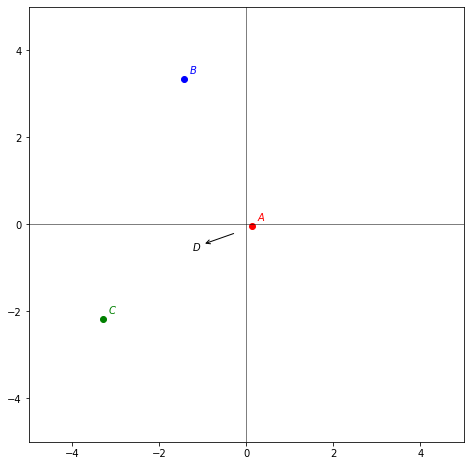

In [17]:
p = point(0.5,0.75)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
# to avoid weird results, set the axis limits before plotting
ax.set_ylim(-5,5)
ax.set_xlim(-5,5)
ax.plot([5,-5],[0,0],color='black',lw=0.5)
ax.plot([0,0],[5,-5],color='black',lw=0.5)
ax.set_aspect(1)
add_to_axes(A,label="$A$",color='red')
add_to_axes(B,label="$B$",color='blue')
add_to_axes(C,label="$C$",color='green')
add_to_axes(idealpoint,label="$D$",color='black')
fig.show()

## Points are where 2 lines meet
Now we'll show our first key geometric result.

If we have two lines $a$ and $b$, their wedge product ("meet") equals a point
$$ P = a \wedge b.$$

As a simple example, let's take a vertical line <span style="color:red">$v$</span> at $x=3$ and a horizontal line
<span style="color:blue">$h$</span>
at $y=4$:
$$ \begin{aligned}
\color{red}{v} &= {e_1 - 3e_0} \\
\color{blue}{h} &= e_2 - 2e_0
\end{aligned}$$

$$ \begin{aligned}
P &= \color{red}{v} \wedge \color{blue}{h}\\ &= (e_1 - 3e_0) \wedge (e_2 - 2e_0)\\ &= e_12 +3e_{20}+2e_{01},
\end{aligned}$$
which is the point $P$ at coordinates $(x,y)=(3,2)$, just like we expect.

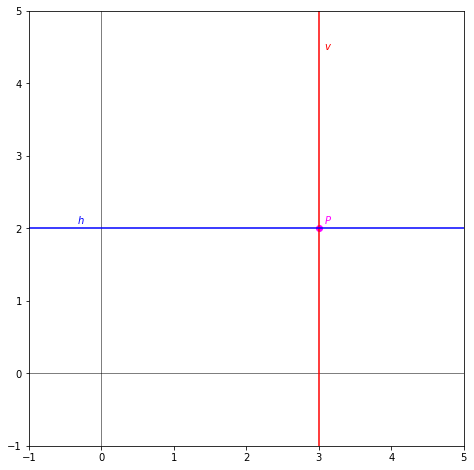

In [18]:
h = line(0,1,-2)
v = line(1,0,-3)
P = v^h
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
# to avoid weird results, set the axis limits before plotting
ax.set_ylim(-1,5)
ax.set_xlim(-1,5)
ax.plot([5,-5],[0,0],color='black',lw=0.5)
ax.plot([0,0],[5,-5],color='black',lw=0.5)
ax.set_aspect(1)
add_to_axes(v,label="$v$",color='red')
add_to_axes(h,label="$h$",color='blue')
add_to_axes(P,label="$P$",color='magenta')
fig.show()

# TODOs
## Content
* _Title slide image_
* Homogeneous coordinates, normalization of points
* ~Ideal lines and points~
* ~2 lines meet at a point~
* inner product, angle measures
* J map(?), vee product
* 2 points are joined by a line
* distance between points
* duality
* ideal norm
* triple products (area of triangle)
* geometric product
* projections, rejections
* reflections, rotations, translations

## Formatting
* set a default plot style